# Pruning on Fashion MNIST

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Imports

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
from timeit import default_timer as timer

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import Fashion MNIST data with one-hot encoding
from tensorflow.examples.tutorials.mnist import input_data
fashion_mnist = input_data.read_data_sets('input/data', one_hot=True)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting input/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting input/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Data format

Now that we've imported our dataset, we can take a look at what format our data is in, and check the shapes of each example image and label array.

In [3]:
# Dataset type
print("Fashion MNIST: {type}".format(type=type(fashion_mnist)))

Fashion MNIST: <class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>


In [4]:
# Shapes of training set and test set
print("Fashion MNIST:")
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=fashion_mnist.train.labels.shape))
print("Test set (images) shape: {shape}".format(shape=fashion_mnist.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=fashion_mnist.test.labels.shape))

Fashion MNIST:
Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [5]:
# Shape of first image in training set
fashion_mnist.train.images[0].shape

(784,)

In [6]:
# Format of labels
fashion_mnist.train.labels[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

### Target classes

The target class labels in the dataset are arrays, and the index of the 1 signifies the piece of clothing to which the image corresponds.

Let's create a dictionary of these integer labels with their associated text labels. 

**Note: ** Mapping between labels and text taken from the original [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) repository.

In [7]:
# Dictionary of labels
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

y = 3 (Dress)


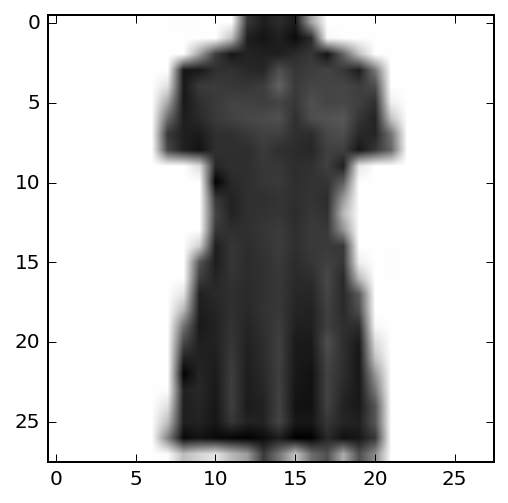

y = 7 (Sneaker)


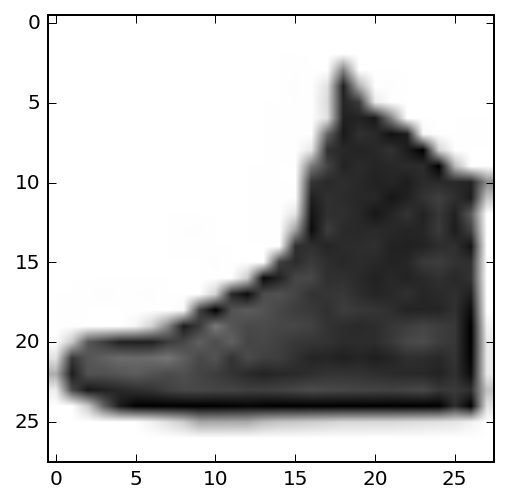

In [8]:
# Get random images and associated label
sample_1 = fashion_mnist.train.images[47].reshape(28,28)
sample_label_1 = np.where(fashion_mnist.train.labels[47] == 1)[0][0]

sample_2 = fashion_mnist.train.images[23].reshape(28,28)
sample_label_2 = np.where(fashion_mnist.train.labels[23] == 1)[0][0]

# Show images and labels
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()

print("y = {label_index} ({label})".format(label_index=sample_label_2, label=label_dict[sample_label_2]))
plt.imshow(sample_2, cmap='Greys')
plt.show()

## Building our neural network

### Setting network parameters

First, let's set some parameters for our network. This includes information about the number of units in each layer, shape of inputs, number of output classes, and number of examples.

In [9]:
# Network parameters
n_hidden_1 = 1000 # Units in first hidden layer
n_hidden_2 = 1000 # Units in second hidden layer
n_hidden_3 = 500 # Units in third hidden layer
n_hidden_4 = 200 # Units in fourth hidden layer
n_input = 784 # Fashion MNIST data input (img shape: 28*28)
n_classes = 10 # Fashion MNIST total classes (0-9 digits)
n_samples = fashion_mnist.train.num_examples

### Creating Placeholders

Next, let's set up a function that creates placeholders for `X` and `Y`, using which we will later pass training data while running our network.

In [10]:
# Create placeholders
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (28*28 = 784)
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [11]:
# Test create_placeholders()
X, Y = create_placeholders(n_input, n_classes)

print("Shape of X: {shape}".format(shape=X.shape))
print("Shape of Y: {shape}".format(shape=Y.shape))

Shape of X: (784, ?)
Shape of Y: (10, ?)


### Initializing parameters

After creating placeholders, we will have to initialize the weights and biases for each layer in our 4-layer neural network.

This implementation uses the **Xavier initialization** for weights

In [12]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [n_hidden_1, n_input]
                        W2 : [n_hidden_2, n_hidden_1]
                        W3 : [n_hidden_3, n_hidden_2]
                        W4 : [n_hidden_4, n_hidden_3]
                        W4 : [n_classes, n_hidden_4]
         
    Returns:
    parameters -- a dictionary of tensors containing W1, W2, W3, W4, W5
    """
    
    # Set random seed for reproducibility
    tf.set_random_seed(42)
    
    # Initialize weights and biases for each layer
    W1 = tf.get_variable("W1", [n_hidden_1, n_input], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    W2 = tf.get_variable("W2", [n_hidden_2, n_hidden_1], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    W3 = tf.get_variable("W3", [n_hidden_3, n_hidden_2], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    W4 = tf.get_variable("W4", [n_hidden_4, n_hidden_3], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    W5 = tf.get_variable("W5", [n_classes, n_hidden_4], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    # Store initializations as a dictionary of parameters
    parameters = {
        "W1": W1,
        "W2": W2,
        "W3": W3,
        "W4": W4,
        "W5": W5
    }

    return parameters

In [13]:
# Test initialize_parameters()
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = {w1}".format(w1=parameters["W1"]))
    print("W2 = {w2}".format(w2=parameters["W2"]))
    print("W3 = {w3}".format(w3=parameters["W3"]))
    print("W4 = {w4}".format(w4=parameters["W4"]))
    print("W5 = {w5}".format(w5=parameters["W5"]))


W1 = <tf.Variable 'W1:0' shape=(1000, 784) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(1000, 1000) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(500, 1000) dtype=float32_ref>
W4 = <tf.Variable 'W4:0' shape=(200, 500) dtype=float32_ref>
W5 = <tf.Variable 'W5:0' shape=(10, 200) dtype=float32_ref>


As expected, our parameters haven't been initialized yet.

### Model

`LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX`

`LINEAR`: $$ Z^{[l]} = W^{[l]}A^{[l-1]} $$

`RELU`: $$ A^{[l]} = max ( 0, Z^{[l]} ) $$

### Forward Propagation

Next, let's implement forward propagation. This function will take in a dictionary of parameters and the input (`X`), to complete the forward pass. It will return the output from the last layer.

In [14]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2", "W3", "W4", "W5"
                  the shapes are given in initialize_parameters

    Returns:
    Z5 -- the output of the last LINEAR unit
    """
    
    # Retrieve parameters from dictionary
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    
    # Carry out forward propagation      # Numpy equivalents:
    Z1 = tf.matmul(W1,X)                 # Z1 = np.dot(W1, X)
    A1 = tf.nn.relu(Z1)                  # A1 = relu(Z1)
    Z2 = tf.matmul(W2,A1)                # Z2 = np.dot(W2, a1) 
    A2 = tf.nn.relu(Z2)                  # A2 = relu(Z2)
    Z3 = tf.matmul(W3,A2)                # Z3 = np.dot(W3,Z2)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.matmul(W4,A3)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.matmul(W5,A4)
    
    return Z5

In [15]:
def sparse_forward_propagation(X, parameters):
    """
    Implements the forward propagation for the pruned model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    """
    
    # Retrieve parameters from dictionary
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
 
    #Converting Weight matrices to a sparse tensor since most of the values are 0
    W1 = tf.contrib.layers.dense_to_sparse(W1)
    W2 = tf.contrib.layers.dense_to_sparse(W2)
    W3 = tf.contrib.layers.dense_to_sparse(W3)
    W4 = tf.contrib.layers.dense_to_sparse(W4)
    W5 = tf.contrib.layers.dense_to_sparse(W5)
    
    #Using sparse matrix multiplication to take advantage of the sparsity
    Z1 = tf.sparse.matmul(W1,X)    
    A1 = tf.nn.relu(Z1)                 
    Z2 = tf.sparse.matmul(W2,A1) 
    A2 = tf.nn.relu(Z2)                
    Z3 = tf.sparse.matmul(W3,A2)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.sparse.matmul(W4,A3)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.sparse.matmul(W5,A4)
    
    return Z5

In [16]:
# Test forward_propagation()
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_input, n_classes)
    parameters = initialize_parameters()
    Z5 = forward_propagation(X, parameters)
    print("Z5 = {final_Z}".format(final_Z=Z5))

Z5 = Tensor("MatMul_4:0", shape=(10, ?), dtype=float32)


### Compute Cost

Next, let's create a function which computes the cost based on the difference between our outputs (`Z3`) and the correct labels (`Y`).

`SOFTMAX: `

`tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(...))` 

In [17]:
def compute_cost(Z5, Y):
    """
    Computes the cost
    
    Arguments:
    Z5 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number_of_examples)
    Y -- "true" labels vector placeholder, same shape as Z5
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # Get logits (predictions) and labels
    logits = tf.transpose(Z5)
    labels = tf.transpose(Y)
    
    # Compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [18]:
# Test compute_cost()
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_input, n_classes)
    parameters = initialize_parameters()
    Z5 = forward_propagation(X, parameters)
    cost = compute_cost(Z5, Y)
    print("cost = {cost}".format(cost=cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = Tensor("Mean:0", shape=(), dtype=float32)


### Backpropagation

We will use the Adam optimizer in this implementation.

`optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)`


### Building the model

Finally, let's combine our previously created functions into one single function called `model()` and run our network.

In [19]:
def model(train, test, learning_rate=0.0001, num_epochs=16, minibatch_size=32, print_cost=True, graph_filename='costs'):
    """
    Implements a four-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    train -- training set
    test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # Ensure that model can be rerun without overwriting tf variables
    ops.reset_default_graph()
    # For reproducibility
    tf.set_random_seed(42)
    seed = 42
    # Get input and output shapes
    (n_x, m) = train.images.T.shape
    n_y = train.labels.T.shape[0]
    
    costs = []
    
    # Create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z5 = forward_propagation(X, parameters)
    # Cost function
    cost = compute_cost(Z5, Y)
    # Backpropagation (using Adam optimizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize variables
    init = tf.global_variables_initializer()
    
    # Start session to compute Tensorflow graph
    with tf.Session() as sess:
        
        # Run initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            
            for i in range(num_minibatches):
                
                # Get next batch of training data and labels
                minibatch_X, minibatch_Y = train.next_batch(minibatch_size)
                
                # Execute optimizer and cost function
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X.T, Y: minibatch_Y.T})
                
                # Update epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True:
                print("Cost after epoch {epoch_num}: {cost}".format(epoch_num=epoch, cost=epoch_cost))
                costs.append(epoch_cost)
        
        # Plot costs
        plt.figure(figsize=(16,5))
        plt.plot(np.squeeze(costs), color='#2A688B')
        plt.xlim(0, num_epochs-1)
        plt.ylabel("cost")
        plt.xlabel("iterations")
        plt.title("learning rate = {rate}".format(rate=learning_rate))
        plt.savefig(graph_filename, dpi=300)
        plt.show()
        
        # Save parameters
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        # Calculate correct predictions
        correct_prediction = tf.equal(tf.argmax(Z5), tf.argmax(Y))
        
        # Calculate accuracy on test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: train.images.T, Y: train.labels.T}))
        print ("Test Accuracy:", accuracy.eval({X: test.images.T, Y: test.labels.T}))
        #Saving the model
        save_graph = tf.train.Saver()
        save_graph.save(sess,'./model.pb')
        return parameters

Cost after epoch 0: 0.4848288826132663
Cost after epoch 1: 0.37299732537777586
Cost after epoch 2: 0.3317094536777907
Cost after epoch 3: 0.30719639480599664
Cost after epoch 4: 0.28736659362738726
Cost after epoch 5: 0.27186093573719783
Cost after epoch 6: 0.2602449401462835
Cost after epoch 7: 0.2461389622578402
Cost after epoch 8: 0.23742645514350516
Cost after epoch 9: 0.22411346343390434
Cost after epoch 10: 0.21664811436269013
Cost after epoch 11: 0.2055310311334747
Cost after epoch 12: 0.19826382283098007
Cost after epoch 13: 0.1905522949704134
Cost after epoch 14: 0.1843779995238976
Cost after epoch 15: 0.1791839527792366


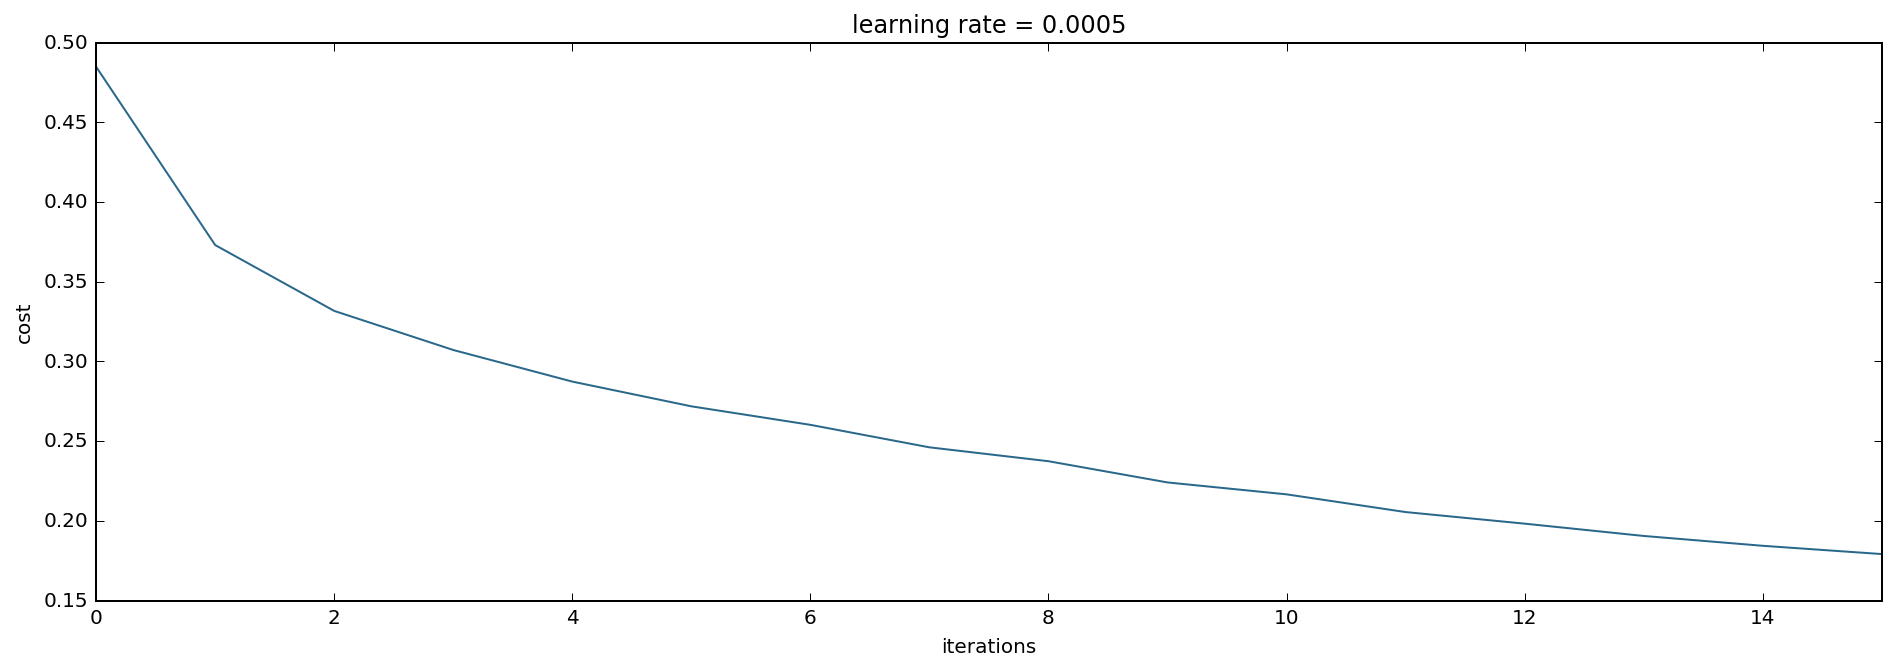

Parameters have been trained!
Train Accuracy: 0.9425091
Test Accuracy: 0.8958


In [20]:
# Running our model on Fashion MNIST
train = fashion_mnist.train
test = fashion_mnist.test

parameters = model(train, test, learning_rate=0.0005, graph_filename='fashion_mnist_costs')

In [21]:
test_acc = []
def eval_pruning(pruning_type,threshold=0,pruning_perc=0):
    """
    Implements a function to test our weight and unit pruning methods
    
    Arguments:
    pruning_type -- weight_pruing / unit_pruning
    threshold -- used to zero out values above threshold
    pruning_perc -- sparsity percentage
    """
    #prune all layers except the last one
    total_ops = len(tf.trainable_variables()) -1
    i=0
    with tf.Session() as sess:
        #Restore the model
        save_graph = tf.train.Saver()
        save_graph.restore(sess,'./model.pb')
        for v in tf.trainable_variables():
            mask = np.ones(v.shape)
            if(i < total_ops):
                if(pruning_type == 'weight_pruing'):
                    #getting the indices of weight values above threshold
                    ids = (sess.run(np.abs(v))) > threshold
                    mask = (ids.astype(float))
                if(pruning_type == 'unit_pruing'):
                    #computing L2-norm of weight matrix
                    unit_norm = np.linalg.norm(sess.run(v),axis=0)
                    #calculate threshold based on sparsity percentage
                    threshold = np.percentile(unit_norm, pruning_perc)
                    ids = unit_norm<threshold
                    #setting the columns to zero
                    mask[:,ids]=0
                #setting the mask onto the weight matrix
                sess.run(v.assign(tf.multiply(v,mask)))
                i+=1
                
        #updating parameters in the dict
        parameters = {
            "W1": tf.trainable_variables()[0],
            "W2": tf.trainable_variables()[1],
            "W3": tf.trainable_variables()[2],
            "W4": tf.trainable_variables()[3],
            "W5": tf.trainable_variables()[4]
        }
        #Calculating test accuracy
        (n_x, m) = train.images.T.shape
        n_y = train.labels.T.shape[0]
        X, Y = create_placeholders(n_x, n_y)
        Z5 = sparse_forward_propagation(X, parameters)
        correct_prediction = tf.equal(tf.argmax(Z5), tf.argmax(Y))     
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Test Accuracy:", accuracy.eval({X: test.images.T, Y: test.labels.T}))  
        test_acc.append(accuracy.eval({X: test.images.T, Y: test.labels.T}))     
        save_graph = tf.train.Saver()
        save_graph.save(sess,'./sparse_model.pb')

In [22]:
def unit_pruning(p_percentage):
    """
    Implements Unit-pruning based on the L2-norm of column of weight matrix
    
    Arguments:
    p_percentage: pruning percentage
    """
    
    eval_pruning('unit_pruing',pruning_perc=p_percentage)
    

unit_pruning(10)
print(test_acc)

INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8456
[0.8456]


In [23]:
def weight_pruing(pruning_perc):
    """
    Implements weight pruning, sets individual weights in the weight matrix to zero
    
    Arguments:
    pruning_perc: pruning percentage
    """
    
    weights = []
    for key,value in parameters.items():
        weights += list(value.flatten())

    threshold = np.percentile(np.abs(weights), pruning_perc)
    eval_pruning('weight_pruing',threshold)

weight_pruing(50)

INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8952


INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8958
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8958
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8945
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.6922
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8952
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.5674
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8933
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.4736
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8874
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.434
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.8675
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.3547
INFO:tensorflow:Restoring parameters from ./model.pb
Test Accuracy: 0.7742
INFO:tensorflow:Restoring 

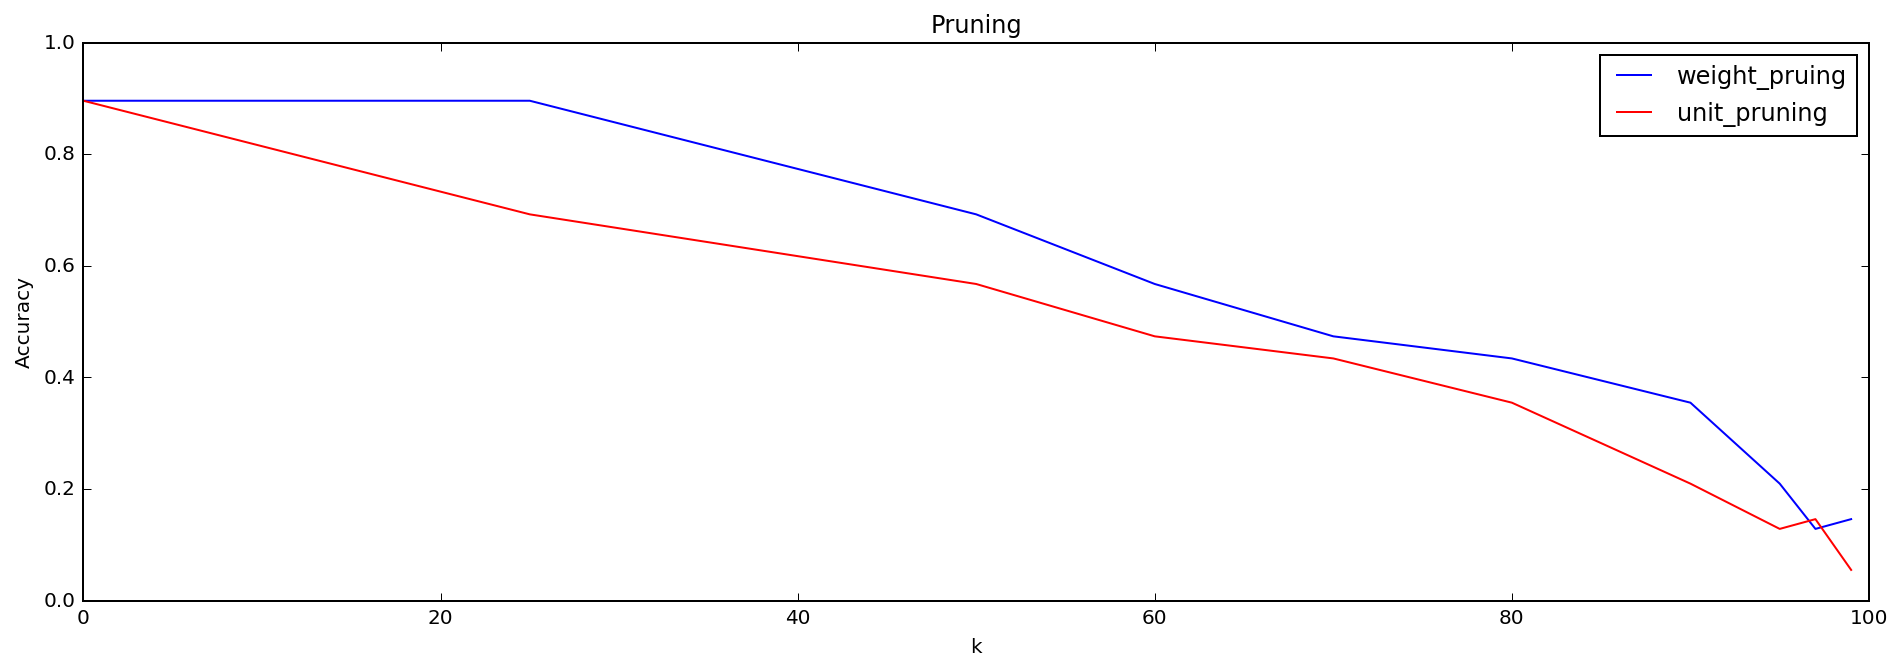

In [24]:
sparcity_perc = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
unit_pruning_acc = []
weight_pruing_acc = []
test_acc = []
for k in sparcity_perc:
    weight_pruing(k)
    weight_pruing_acc.append(test_acc[0])
    test_acc = []
    unit_pruning(k)
    unit_pruning_acc.append(test_acc[0])
plt.figure(figsize=(16,5))
plt.plot(sparcity_perc, weight_pruing_acc,  '-b', label='weight_pruing')
plt.plot(sparcity_perc, unit_pruning_acc,  '-r', label='unit_pruning')
plt.xlim(0, 100)
plt.ylim(0,1.0)
plt.ylabel("Accuracy")
plt.xlabel("k")
plt.title("Pruning")
plt.legend()
plt.show()

## Conclusion

From the above graph, we can draw the conclusion that weight pruning is better than unit pruning as by zeroing out the columns we could be losing critical features
Even after pruning 90% of the weights the accuracy dropped from 89% to just 81%, and also reducing the model size and gaining computational speed-ups. 

The results hint at the possibility that the baseline models in these experiments are perhaps severely over-parameterized at the outset and a viable alternative for model compression might be to simply reduce the number of hidden units while maintaining the model's dense connection structure, exposing a similar trade-off in model size and accuracy.

Also, I feel large-sparse is typically better than small-dense, for a fixed number of non-zero parameters or memory footprint.

When you are time-constrained, it is better to train a simple, smaller network from scratch than prune a large network. It is the architectures obtained through the pruning process, not the learned weights that prove valuable. Such architectures are powerful when trained from scratch. Furthermore, these architectures are easy to approximate without any further pruning: we can prune once and obtain a family of new, scalable network architectures for different memory requirements.